In [1]:
import os
from glob import glob
from pprint import pprint # pretty printing

import pandas as pd      # data structures
import numpy as np       # basic numerical operations
import altair as alt     # plotting library
from ipywidgets import interact, fixed # buttons and stuff
# with respect to https://github.com/Chekos/blog-posts/tree/master/altair%20%2B%20ipywidgets

# tell plotting library not to try and hold everything in memory
alt.data_transformers.enable('json')
# and let it render good
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

## 1. *Geddat that data*
we reduced our spiketime data into 'long' format data - where every row is an observation (in this case spikes) and every column a variable.

We also combined all cells into a single file with clean_out_dir.m. Let's load it

In [30]:
# start with tuning curves
tc_dir = os.path.join(os.getcwd(),'data','tones')
# make a string with a wildcard to search for the file
tc_search = tc_dir + os.sep + "*combined*.csv"
tc_fns = glob(tc_search)

#what did we get?
print("""\nDirectory: {}
          \nSearch string: {}
          \nGlobbed Filenames: {}""".format(tc_dir, tc_search, tc_fns))



Directory: /Users/jonny/GitHub/bootcamp_2018/data/tones
          
Search string: /Users/jonny/GitHub/bootcamp_2018/data/tones/*combined*.csv
          
Globbed Filenames: ['/Users/jonny/GitHub/bootcamp_2018/data/tones/out_combined_tones.csv']


Load it!

In [31]:
if len(tc_fns) == 1:
    # make a pandas dataframe out of our .csv file
    df = pd.read_csv(tc_fns[0])
    
# print the first n rows (default 5, try giving another number as an argument)
df.head()

,amps,cell,dur,expt,freqs,rep,spikes
0,40,1,25,tuning_curve,4000.00,1,1.566667
1,40,1,25,tuning_curve,5656.85,1,21.633333
2,40,1,25,tuning_curve,11313.70,1,26.866667
3,40,1,25,tuning_curve,11313.70,1,36.366667
4,40,1,25,tuning_curve,22627.40,1,16.666667


How many cells do we have?

In [18]:
print("There are {} unique cells: {}".format(
        len(df['cell'].unique()), 
        df['cell'].unique()
    ))

There are 2 unique cells: [1 7]


The data is structured such that each row is a spike, and each column describes the spike.

Look at the rest of the column names - we have 

* **expt**: what type of experiment this data is from
* **freqs**: the frequency of the pure tone
* **amps**: the amplitude of the tone
* **rep**: the repetition of each amplitude/frequency combination
* **spikes**: the time of the spike (in ms from stimulus onset)

Lets check what `unique` frequencies and amplitudes we have

In [23]:
uq_freqs = df['freqs'].unique()
uq_amps  = df['amps'].unique()

print('Frequencies:\n')
pprint(uq_freqs)
print('\n\nAmplitudes:\n')
pprint(uq_amps)

Frequencies:

array([ 4.00000e+03,  5.65685e+03,  1.13137e+04,  2.26274e+04,
        1.00000e+03,  1.41421e+03, -1.00000e+00,  2.82843e+03,
        1.60000e+04,  6.40000e+04,  2.00000e+03,  8.00000e+03,
        3.20000e+04,  4.52548e+04])


Amplitudes:

array([40, 55, 70])


We presented probably like 9 stimuli:

## 2. Spike Raster

We make a classic raster first.

In [68]:

def spike_raster(cell, data):
    # we first declare a Chart object, subsetting our data to a single cell
    # we then mark_circles with the encoding (map from data to graphics)
    
    duration = data.loc[0].dur
    
    chart = alt.Chart(data[data['cell'] == cell]).mark_circle().encode(
        x = alt.X('spikes'),      # X axis will be spike time
        y = alt.Y('rep' ),        # Y is the stimulus repetition
        size = alt.value(5),      # make the dots small
        opacity=alt.value(1.),    # black
        color=alt.condition(
            (alt.datum.spikes >= 0) & (alt.datum.spikes<=duration),
            alt.value('red'), # and opaque
            alt.value('black')
        )
        
    ).properties(
        width = 200,
        height = 30,
    ).facet(
        row='freqs', # split the plot into rows by ici
        column='amps'
    )
    
    
    return chart



In [69]:
interact(spike_raster,cell = sorted(df['cell'].unique()), data=fixed(df));

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnY2VsbCcsIG9wdGlvbnM9KDEsIDcpLCB2YWx1ZT0xKSwgT3V0cHV0KCkpLCBfZG9tX2NsYXNzZXM9KHUnd2lkZ2XigKY=


What if we want to summarize?


In [4]:
# select just spikes within stim
stim_inds = np.logical_and(df['spikes']>0, df['spikes']<2000)
data_stim = df[stim_inds]

# summarize 


In [5]:
n_spikes = data_stim.groupby(['cell','icis','rep'])['spikes'].count()
n_spikes

cell  icis  rep
134   1     1      16
            2      10
            3      28
            4      14
            5       8
            6       8
            7       2
            8       8
            9      16
            10     16
            11      6
            12     20
            13     22
            14      6
            15      8
            16     18
            17      6
            18     14
            19     14
            20      2
      2     1      20
            2      12
            3      24
            4       2
            5      18
            6       8
            7      26
            8       4
            9       4
            11      2
                   ..
172   128   11     15
            12      3
            13      5
            14      1
            15      6
            16      5
            17      2
            18     12
            19      8
            20      6
      256   1       7
            2       7
            3       8
            4   

In [6]:
mean_spikes = pd.DataFrame(n_spikes.groupby(['cell','icis']).mean())
mean_spikes

spikes
cell icis           
134  1     12.100000
     2     11.333333
     4      6.857143
     8      4.111111
     16     8.333333
     32    14.000000
     64    14.500000
     128   17.700000
     256   19.100000
172  1      6.050000
     2      5.666667
     4      3.428571
     8      2.055556
     16     4.166667
     32     7.000000
     64     7.250000
     128    8.850000
     256    9.550000

In [7]:
sd_spikes = pd.DataFrame(n_spikes.groupby(['cell','icis']).std())
sd_spikes

spikes
cell icis           
134  1      6.851047
     2      8.622815
     4      5.695574
     8      2.698341
     16     5.235625
     32     8.137704
     64     7.783248
     128   10.588474
     256    8.372260
172  1      3.425523
     2      4.311408
     4      2.847787
     8      1.349171
     16     2.617812
     32     4.068852
     64     3.891624
     128    5.294237
     256    4.186130

Recombine them


In [8]:


stim_summary = pd.DataFrame.join(mean_spikes,sd_spikes, lsuffix='mean')
stim_summary = pd.DataFrame(stim_summary.to_records())
stim_summary['sd_low'] = stim_summary['spikesmean']-stim_summary['spikes']
stim_summary['sd_hi'] = stim_summary['spikesmean']+stim_summary['spikes']


stim_summary

,cell,icis,spikesmean,spikes,sd_low,sd_hi
0,134,1,12.100000,6.851047,5.248953,18.951047
1,134,2,11.333333,8.622815,2.710518,19.956148
2,134,4,6.857143,5.695574,1.161569,12.552717
3,134,8,4.111111,2.698341,1.412770,6.809452
4,134,16,8.333333,5.235625,3.097709,13.568958
5,134,32,14.000000,8.137704,5.862296,22.137704
6,134,64,14.500000,7.783248,6.716752,22.283248
7,134,128,17.700000,10.588474,7.111526,28.288474
8,134,256,19.100000,8.372260,10.727740,27.472260
9,172,1,6.050000,3.425523,2.624477,9.475523


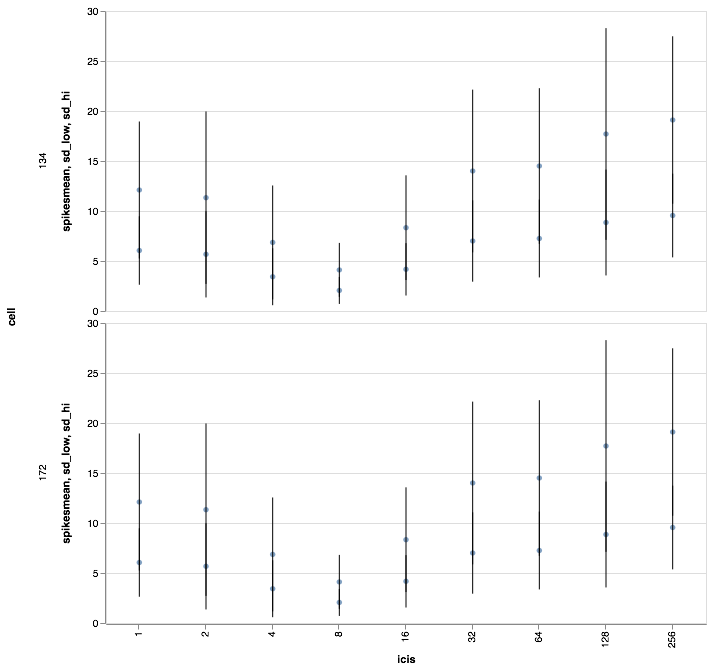

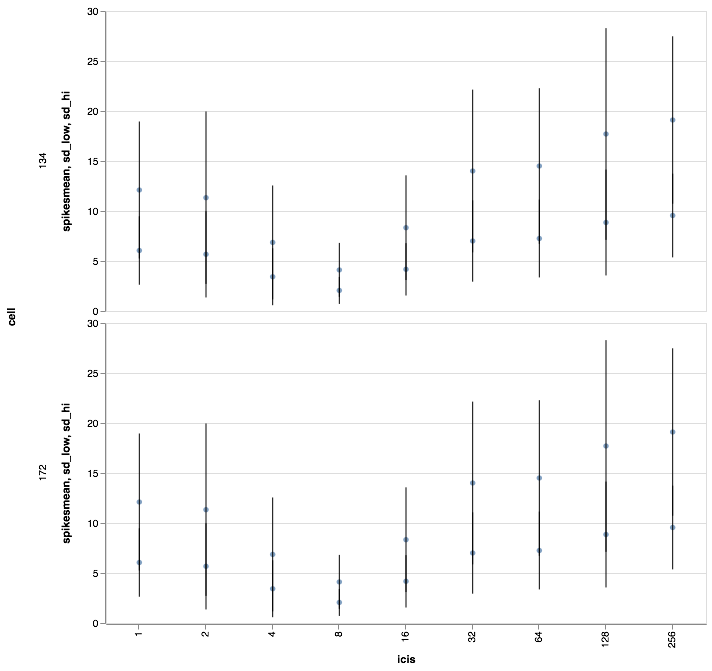

In [16]:
points = alt.Chart(stim_summary).mark_circle(
            ).encode(
                x=alt.X('icis:O'),
                y=alt.Y('spikesmean')
            ).properties(
                width = 600,
                height = 300
            )

bars = alt.Chart(stim_summary).mark_rule().encode(
y=alt.Y('sd_low'),
y2=alt.Y('sd_hi'),
x=alt.X('icis:O'))

chart = points+bars

chart.facet(row='cell:N',data=stim_summary)
